In [1]:
import tensorflow

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
train_data = np.load('flower_imgs.npy')
labels = np.load('flower_labels.npy')
num_classes = 5
x_train, x_test, y_train, y_test = train_test_split(train_data, labels,
                                                    stratify=labels, 
                                                    test_size=0.10)

In [4]:
# x_train, x_test, y_train, y_test = x_train.astype(np.float32), x_test.astype(np.float32), y_train.astype(np.float32), y_test.astype(np.float32) 


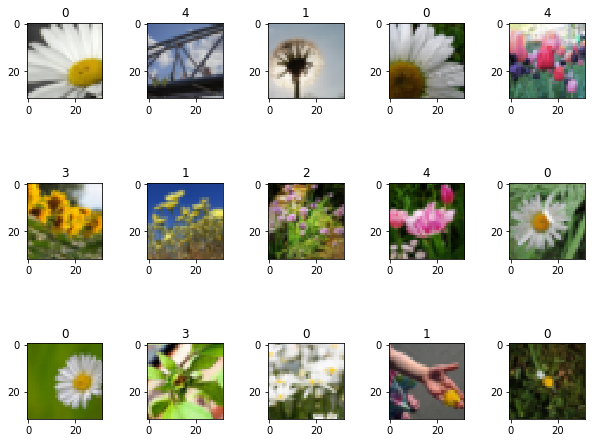

In [5]:
plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.6, hspace=0.4)
# figure
x, y = 5, 3
for i in range(x*y):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i], interpolation='nearest')
    plt.title(y_train[i])   
plt.show()

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [8]:
class ImgLoader(Dataset):
    def __init__(self, x, y,iscuda=False):
        self.X = np.array(x, dtype = np.float32)
        self.y = np.array(y, dtype = np.float32)
#         self.cuda = iscuda
    
    def __getitem__(self, index):
        x_val = self.X[index]
        x_val = torch.from_numpy(x_val).permute(2, 1, 0)
        y_val = torch.from_numpy(np.array([self.y[index]]))
#         if self.cuda:
#             x_val = x_val.cuda()
#             y_val = y_val.cuda()
        return x_val, y_val

    def __len__(self):
        return len(self.X)

In [9]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features= 12)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features= 12)
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features= 24)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features= 24)
        self.relu4 = nn.ReLU()

        self.fc = nn.Linear(in_features=16 * 16 * 24, out_features=num_classes)

#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features
        
    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)

        output = self.pool(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)

        output = self.conv4(output)
        output = self.bn4(output)
        output = self.relu4(output)

        output = output.view(-1, 16 * 16 * 24)

        output = self.fc(output)

        return output

In [10]:
use_cuda = torch.cuda.is_available()
img_loader = ImgLoader(x_train, y_train, use_cuda)

In [11]:
trainloader = DataLoader(img_loader, batch_size = 5, shuffle=True, num_workers=4)

In [12]:
def test(model):
#     model.train(False)
    model.eval()
    test_acc = 0.0
    count = 0
    for x,y in zip(x_test,y_test):
        x = torch.from_numpy(np.array([x])).permute(0, 3, 1, 2)
        x = x.type(torch.FloatTensor)
        if use_cuda:
            x = x.cuda()
        out = model(Variable(x))
#         print(out.shape)
        label = np.argmax(out.data.numpy()) # needs to be optimized
        if y == label:
            count += 1
    test_acc = count / len(x_test)
#     print(count * 1.0 / len(x_test))
    return test_acc

In [13]:
epochs = 10
criterion = nn.CrossEntropyLoss()
net = ConvClassifier()
if use_cuda:
    net = net.cuda()
    
    

In [14]:
optimizer = optim.Adam(params=net.parameters(), lr=0.001)

for epoch in range(epochs):
    losses = []
    train_loss = 0.0
    train_acc = 0.0
    net.train()
    for i ,(x, y) in enumerate(trainloader):
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        optimizer.zero_grad()

        inputs =  Variable(x)
        output = net(inputs)
#         print('output: ', output)
        targets = Variable(y.squeeze(1))
#         print('targets', targets)
        targets = targets.type(torch.LongTensor)
#         print('tens targets: ', targets)
        
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        _, prediction = torch.max(output.data, 1)

        train_acc += torch.sum(prediction == targets.data)
    print("len(x) = ", len(x))
    train_acc = train_acc/3890
    test_acc = test(net)
    train_loss = np.average(losses)
#         break
#     break
#     if (epoch+1) % 1 == 0:
#     print('Epoch %d Loss %.4f  ' % (epoch+1, np.average(losses)))
#     print('test accuracy')

    print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch+1, train_acc, train_loss,test_acc))
        

len(x) =  5
Epoch 1, Train Accuracy: 0.45989717223650384 , TrainLoss: 1.347249493998856 , Test Accuracy: 0.48036951501154734
len(x) =  5
Epoch 2, Train Accuracy: 0.5763496143958869 , TrainLoss: 1.0558082258333583 , Test Accuracy: 0.5242494226327945
len(x) =  5
Epoch 3, Train Accuracy: 0.6431876606683805 , TrainLoss: 0.9243943625271014 , Test Accuracy: 0.5334872979214781
len(x) =  5
Epoch 4, Train Accuracy: 0.6910025706940874 , TrainLoss: 0.8124636637099605 , Test Accuracy: 0.5242494226327945
len(x) =  5
Epoch 5, Train Accuracy: 0.7275064267352185 , TrainLoss: 0.7157549337510278 , Test Accuracy: 0.5173210161662818
len(x) =  5
Epoch 6, Train Accuracy: 0.7763496143958869 , TrainLoss: 0.6072799618185946 , Test Accuracy: 0.49191685912240185
len(x) =  5
Epoch 7, Train Accuracy: 0.8200514138817481 , TrainLoss: 0.49044704548463913 , Test Accuracy: 0.5034642032332564
len(x) =  5
Epoch 8, Train Accuracy: 0.8465295629820051 , TrainLoss: 0.41642963465609634 , Test Accuracy: 0.5080831408775982
len(